<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/main/4_Wetness_index%E3%81%A8STI%E3%81%AE%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# wetness indexとSTIの計算

* GIS Day in 東京 2019 Eコース
* Pythonを用いたDEM処理
* 首都大学東京 都市環境学部 地理環境学科 中山大地
* 2019年12月21日 首都大学東京 南大沢キャンパス
* [github repository: www.github.com/bokutachi256/gisday2019](https://www.github.com/bokutachi256/gisday2019)
* 参考になるページ
  - [gdal python のマニュアルページ](https://gdal.org/python/)
  - [pyshedsのページ](https://github.com/mdbartos/pysheds)
* 更新履歴
  - 2022年6月16日：pysheds仕様変更に伴う対応版

# はじめに

この章ではwetness indexとSTI（sediment transport index）を求めます．
どちらも任意の点の傾斜量とその点より上流の流域面積から求めることができます．

流域面積を求めるには流路網処理が必要になります．
手そのための手順は以下になります．

1. すべてのメッシュで流下方向を求める
1. 流下方向をもとに流域面積（Flow Accumulation）を求める

これらは複雑な計算が必要ですが，`pysheds`ライブラリを使うことにより
簡単に求めることができます．


# 計算の準備

## ライブラリのインストール

標準ではGoogle Colaboratoryに用意されていないライブラリ（`pysheds`）を，マジックコマンドでpipを使ってインストールします．
マジックコマンドはGoogle Colaboratory上でUNIXのコマンドを実行する方法です．

インストールする必要があるライブラリは`pysheds`のみですが，
`numba`のバージョン違いでエラーが出る場合があるので
`numba`と`pip`もアップデートします．


In [ ]:
!pip install -U pip
!pip install -U numba
!pip install pysheds

## ライブラリのインポート

このプログラムでは，以下のライブラリを使用します．

* `numpy`: 多次元配列計算のライブラリ．
* `matplotlib.pyplot`: グラフ作成・データ可視化ライブラリ．
* `matplotlib.colors`: カラーライブラリ．
* `pysheds`：流路網・流域処理のライブラリ．GeoTiffの読み書きにも使用．
* `google.colab`: Google Colaboratory用ライブラリ．google driveのマウントに使用．


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Google Driveのマウント


`drive.mount`を使ってGoogle DriveをGoogle Colaboratoryにマウントします．
`drive.mount`の引数はGoogle Colaboratory内のマウントポイントです．
このマウントポイントで示されたディレクトリにGoogle Driveのルートディレクトリ（マイドライブ）が接続されます．

`drive.mount`が実行されると，どのGoogleアカウントで接続するか聞かれます．
適切なアカウントを指定してアクセス権を与えます．
その後認証コードが発行されますので，それをコピーしてテキストボックスにペーストしてください．
これでGoogle Driveがマウントされます．

マイドライブの中に作業用のディレクトリ`gisday2019`を作成してください．
この作業用ディレクトリへのフルパスは`/drive/My Drive/gisday2019`になります．
これを変数`base_dir`に格納しておきます．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/DEM/"

In [2]:
# ローカルで実行する場合は作業用ディレクトリの設定のみ必要
base_dir = "./DEM/"

## DEMと傾斜量の読み込み


`pysheds`の`Grid`オブジェクトを使ってDEMと傾斜量のGeoTiffを読み込みます．
`Grid.from_raster`を使うと
インスタンスの生成とGeoTiffの読み込みが同時にできます．
第一引数は読み込むGeoTiffのファイル名，第二引数はインスタンス内での名前です．
DEMと傾斜量の二つを読み込みますので，
インスタンス名はそれぞれ`demgrid`と`slopegrid`にしました．
標高値と傾斜量はそれぞれ`demgrid.dem`と`slopegrid.slope`でアクセスできます．


傾斜量のデータは度単位で格納されていることが前提です．

In [2]:
grid = Grid.from_raster(base_dir + 'output_dem_reprojected.tif')
dem = grid.read_raster(base_dir + 'output_dem_reprojected.tif')

grid = Grid.from_raster(base_dir + 'output_slope_deg.tif')
slope = grid.read_raster(base_dir + 'output_slope_deg.tif')

読み込んだDEMは「データなし」の値として`dem.nodata`に-9999が格納されています．
この後で行う流下方向の計算では，海や湖などの流下方向の計算を行わないメッシュの値を-3.402823e+38にしておけば
そのメッシュの計算は行いません．
そのため，値がが`dem.nodata`のセルを-3.402823e+38で置き換えます．

In [3]:
dem[dem == dem.nodata] = -3.402823e+38
dem.nodata = -3.402823e+38


# 流域面積の計算


Flow Accumulationの計算には以下の手順が必要になります．
これらは`pysheds`の機能で求めることができます．

1. すべてのメッシュで流下方向を求める
1. 流下方向をもとに流域面積（Flow Accumulation）を求める

## DEMの凹陥地と平坦地の処理

流下方向の基本的な求め方は，
任意のメッシュの周囲の8点を見て下方向に最も傾斜が急な方向をたどっていくものです．
しかし離散化の都合でDEM必ず凹陥地が発生し，
そこで流路網が終了してしまいます．
また，完全に平坦な部分では最大流下方向が求まらないため，
流路のループや交差が発生する可能性があります．

これらの矛盾を含まない完全な流路網を求めるには，
凹陥地と平坦地の処理が必要です．

`pysheds`には凹陥地を処理する`fill_depressions`メソッドと
平坦地を処理する`resolve_flats`メソッドがあり，
これらを使うと上記の処理が簡単にできます．



凹陥地を埋める`fill_depression`メソッドの引数は2個です．
引数`data`は凹陥地処理対象となるオブジェクトを指定し，ここでは`dem`になります．
引数`out_name`は処理済みDEMの出力先で，ここでは`flooded_dem`にしました．

次に`flooded_dem`‘に対して平坦地処理を行います．
`resolve_flats`‘も引数が2個あり，
引数`data`が平坦地処理の対象データ，
引数`out_name`が処理済みDEMの出力先です．
処理の対象は`flooded_dem`‘，
出力先は`inflated_dem`にしました．

以上で凹陥地と平坦地が処理された`demgrid.inflated_dem`が求まります．



In [4]:
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)


確認のためオリジナルのDEMと処理済みDEMの差分を表示してみましょう．

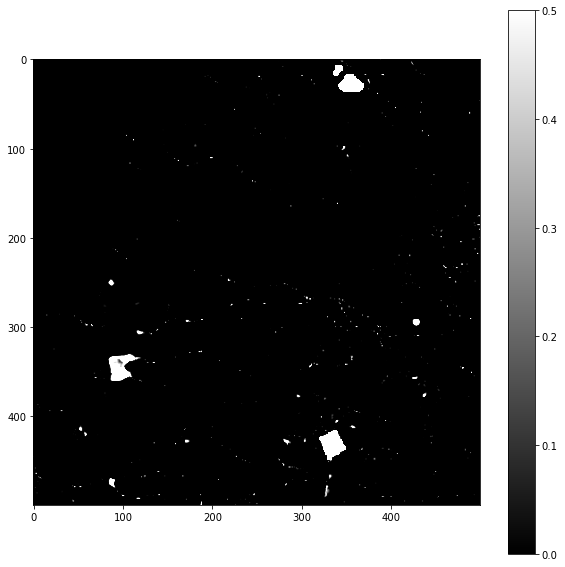

In [5]:
plt.figure(figsize = (10,10))
im = plt.imshow((inflated_dem - dem)[500:1000, 2000:2500], cmap = "gray", vmax = 0.5)
#im = plt.imshow(dem, cmap = "gray")
#im = plt.imshow(dem, cmap = "gray", vmax = 0.5)
plt.colorbar(im)
plt.show()

## 流下方向の計算

DEMの準備ができたので，流下方向を計算します．
流下方向の計算には流下方向マップが必要です．
これは流下方向の8方位をどのような値で表すかです．
ArcGISでは以下のような値になっています．

流下方向|北|北東|東|南東|南|南西|西|北西
-:|-:|-:|-:|-:|-:|-:|-:|-:
dirmap|64|128|1|2|4|8|16|32

今回は`pysheds`でも同じ値を使います．
流下方向マップをタプル`dirmap`に格納します．

In [6]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

次に`flowdir`メソッドを使って流下方向を計算します．
引数`data`は処理対象のDEMですので`inflated_dem`を，
引数`out_name`は求まった流下方向の出力先で`dir`を指定しました．
引数`dirmap`は流下方向マップで，
引数`routing`は流下方法のタイプになります．
通常は8方位の流下方向を用いますので`d8`にします．

In [7]:
dir = grid.flowdir(inflated_dem, dirmap = dirmap, routing = 'd8')

この計算はDEMが大きいとそれなりに時間がかかります．
計算が終わったら図化して確認してみましょう．

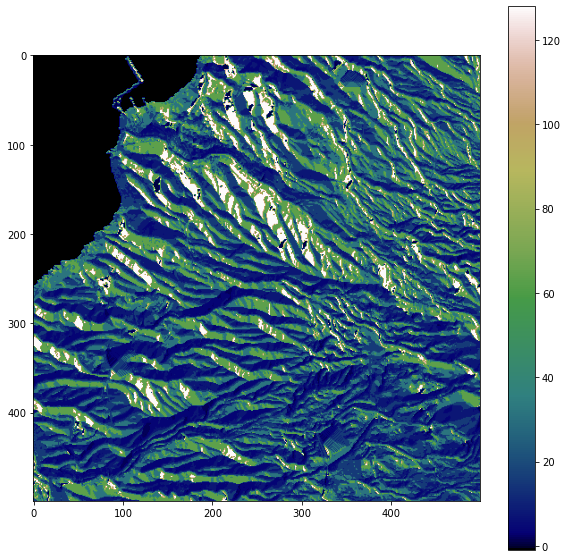

In [9]:
plt.figure(figsize = (10,10))
im = plt.imshow(dir[500:1000, 2000:2500], cmap = "gist_earth")
plt.colorbar(im)
plt.show()

## 流域面積（flow accuulation）の計算

流域面積（flow accumulation） $S(c_i)$ は以下の式で定義できます．

$$
S(c_i) = S(c_i)+\sum_u^n{S(c_u)}
$$

$S(c_u)$は任意のメッシュ$c_i$の上流メッシュの面積を表します．
すなわち$\sum_u^n{S(c_u)}$は任意のメッシュ$c_i$よりも上流部の合計面積になります．

`accumulation`メソッドを使って流域面積（flow accumulation）を計算します．
引数`data`は入力する流下方向データ，
引数`dirmap`は流下方向マップ，
引数`out_name`は計算結果の出力先です．
計算結果の流域面積は`demgrid.acc`でアクセスできます．

流域面積は非常に大きな値になる可能性があります．
このため，型が`int64`（64ビット整数）になっています．
`demgrid.acc.dtype`で確認してみましょう．

In [10]:
acc = grid.accumulation(dir, dirmap = dirmap)

`imshow`で図化します．
流域面積は上流から合流するたびに値が増加していきます．
このため，最大値と最小値の差が非常に大きくなります．
最小値は`1`で，これはそのメッシュよりも上流にメッシュがないことを示しており，
流路の最上流端になります．

生の値で図化すると流域面積の大きいメッシュ（つまり主流路）のみしか見えないので，
対数で正規化して表示します．

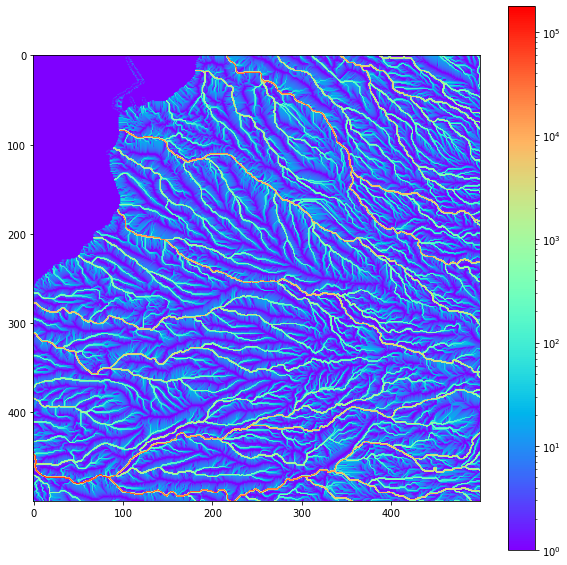

In [11]:
plt.figure(figsize = (10,10))
im = plt.imshow(acc[500:1000, 2000:2500], cmap = "rainbow", norm = colors.LogNorm(1, acc.max()))
plt.colorbar(im)
plt.show()

## 流域面積をGeoTiffで保存する．

流域面積`demgrid.acc`の型は64ビット整数です．
この型はGeoTiffとして保存できないため，
`demgrid.acc`を64ビット浮動小数点（`np.float64`）にキャストして
`demgrid`に追加します．
その後で`to_raster`を使ってGeoTiffに書き出します．

In [14]:
acc[dem == dem.nodata] = -9999
acc.nodata = -9999


In [12]:

grid.to_raster(acc, base_dir + 'output_acc.tif', target_view = acc.viewfinder, blockxsize = 16, blockysize = 16)

# wetness indexの計算


## wetness indexの定義

wetness indexは湿潤の度合いを示す地形量で，
任意の点の流域面積と傾斜量から求まります．
この値はあくまでも地形的に湿潤になるかどうかを表しているものであり，
実際に湿潤かどうかを表すものではありません．

wetness index $wi$は以下の式で定義できます．

$$
wi =
    \mathrm{ln}\left(\frac{As}{\mathrm{tan}\beta}\right)
$$

ここで$As$は任意の点での流域面積，$\mathrm{tan}\beta$は
同じ点における傾斜量$\beta$の正接（$\mathrm{tan}$）です．

$\mathrm{tan}\beta$はすでにGeoTiffから読み込んだ`slopegrid.slope`そのものであり，
$As$は先ほど求めた流域面積`demgrid.acc`になります．
ただし`demgrid.acc`はメッシュ数を表しているため，
1メッシュあたりの面積を乗じる必要があります．


## wetness indexの計算


1メッシュあたりの面積は`demgrid`のアフィンパラメーター`demgrid.affine`の第一要素と第五要素を乗じて絶対値を取ったものになります．

$\mathrm{ln}$は$e$を底とする対数（自然対数）で，
`np.log`で計算できます．


In [13]:
mesh_area = np.abs(dem.affine[0] * dem.affine[4])
wetnessindex = np.log((acc * mesh_area) / np.radians(slope))

/tmp/ipykernel_13925/3354219488.py:2: RuntimeWarning: divide by zero encountered in true_divide
  wetnessindex = np.log((acc * mesh_area) / np.radians(slope))
/tmp/ipykernel_13925/3354219488.py:2: RuntimeWarning: invalid value encountered in true_divide
  wetnessindex = np.log((acc * mesh_area) / np.radians(slope))


wetnessindexも`imshow`を使って図化してみましょう．

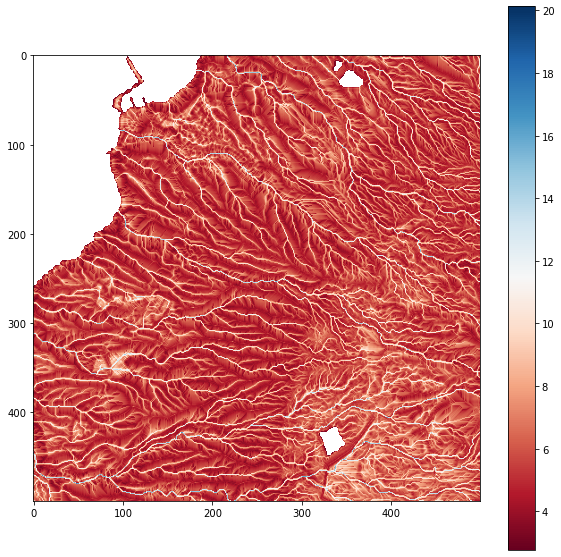

In [14]:
plt.figure(figsize = (10,10))
im = plt.imshow(wetnessindex[500:1000, 2000:2500], cmap = "RdBu")
plt.colorbar(im)
plt.show()

## wetness indexをGeoTiffで保存する

wetness indexもGeoTiffで保存しましょう．
ただし，海面や内水面などの平坦地では，割り算の分母が0になるため
`wetnessindex`の値が無限大（`inf`）になっています．
この部分はNoDataとして処理する必要があります．

`wetnessindes`の値が無限大のメッシュの値を`-9999`で置き換えます．


In [15]:
wetnessindex[wetnessindex == -np.inf] = -9999
wetnessindex.nodata = -9999

`add_gridded_data`を使って`wetenssindex`をオブジェクト`demgrid`に追加します．
その際に，NoData値を`-9999`にします．
また`wetnessindex`は64ビット浮動小数点ですがここまでの精度は必要ありませんし，
ファイルサイズを節約するために32ビット浮動小数点にキャストします．

In [16]:
grid.to_raster(wetnessindex.astype(np.float32), base_dir + 'output_wetnessindex.tif', target_view = wetnessindex.viewfinder, blockxsize = 16, blockysize = 16)

# sediment transport indexの計算

## STIの定義

sediment transport index （STI）は侵食と堆積のポテンシャルを表す地形量で，
傾斜量と上流域の面積から求まります．

STI ($\tau$)は以下の式で定義されます．

$$
\tau =
  \left(\frac{As}{22.13}\right)^{0.6} \times \left(\frac{\mathrm{sin}\beta}{0.0896}\right)^{1.3}
$$

ここで$As$は任意の点の上流域の流域面積，
$\beta$はその点の傾斜量です．
$As$は`demgrid.acc`から，$\beta$は`slopegrid.slope`から求めることができます．

## STIの計算

まず$\mathrm{sin} \beta$を求めます．
`slopegrid.slope`は$\mathrm{tan} \beta$なので，
逆正接`np.arctan`でラジアンに変換してから$\mathrm{sin} \beta$を求めます．

In [17]:
sinb = np.sin(np.radians(slope))

$As$は流域面積`demgrid.acc`から求めます．
wetnessindexと同様に1メッシュあたりの面積を乗じる必要があり，
1メッシュあたりの面積は`demgrid`のアフィンパラメーター`demgrid.affine`の第一要素と第五要素を乗じた絶対値になります．
これを`demgrid.acc`に乗じて`a_s`を求めます．

In [18]:
mesh_area = np.abs(dem.affine[0] * dem.affine[4])
a_s = acc * mesh_area

最後にSTIを計算します．
べき乗は`np.power`を使います．
第二引数が指数になります．

In [19]:
sti = np.power(a_s / 22.13, 0.6) * np.power(sinb / 0.0896, 1.3)

STIも`imshow`で図化します．
stiにはべき関数（$As$）が含まれていますので，
対数変換して表示します．

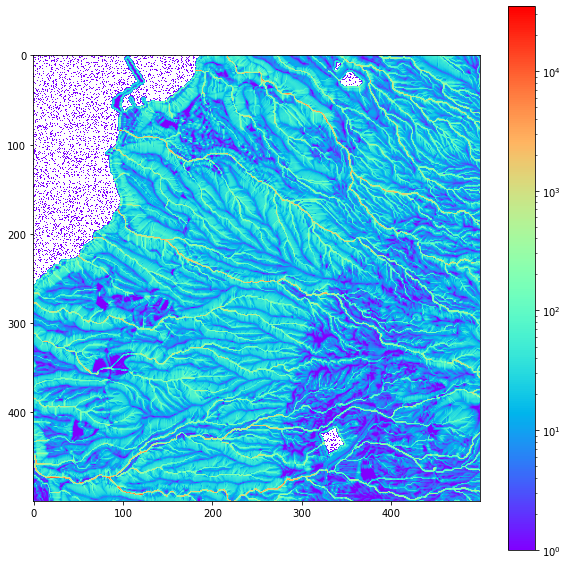

In [20]:
plt.figure(figsize = (10, 10))
im = plt.imshow(sti[500:1000, 2000:2500], cmap = "rainbow", norm = colors.LogNorm(1, sti.max()))
#im = plt.imshow(sti[500:1000, 2000:2500], cmap = "rainbow")
plt.colorbar(im)
plt.show()

流路沿いでSTIが高く，運搬力が高いことがわかります．
STIが低い部分は地形的な堆積場になると考えられます．

## STIをGeoTiffで保存する

STIをGeoTiffで保存します．
`sti`は64ビット浮動小数点なので，
32ビット浮動小数点にキャストして`add_gridded_data`で`demgrid`に追加します．
その後で`to_raster`を使ってGeoTiff型式で保存します．

In [21]:
sti_log = np.log10(sti)
sti_log[sti_log == -np.inf] = -9999
sti_log.nodata = -9999

/tmp/ipykernel_13925/329630726.py:1: RuntimeWarning: divide by zero encountered in log10
  sti_log = np.log10(sti)


In [22]:
sti[dem == dem.nodata] = -9999
sti.nodata = -9999

In [23]:
grid.to_raster(sti.astype(np.float32), base_dir + 'output_sti.tif', target_view = sti.viewfinder, blockxsize = 16, blockysize = 16)

grid.to_raster(sti_log.astype(np.float32), base_dir + 'output_stilog.tif', target_view = sti.viewfinder, blockxsize = 16, blockysize = 16)

## 全部入り

In [24]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Google Colaboratoryで実行しているかローカルで実行しているかを判別する
# Google Colaboratoryで実行している場合はgoogle.colabをインポートし，drive.mountを実行する．
# さらに作業用ディレクトリを指定する．
# ローカルで実行する場合は作業用ディレクトリの設定のみ実行する

if 'google.colab' in sys.modules:
  !pip install -U pip
  !pip install -U numba
  !pip install pysheds
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "/content/drive/My Drive/DEM/"
else:
  base_dir = "./DEM/"

  from pysheds.grid import Grid
  from pysheds.view import Raster, ViewFinder

# DEMと傾斜量の読み込み
grid = Grid.from_raster(base_dir + 'output_dem_reprojected.tif')
dem = grid.read_raster(base_dir + 'output_dem_reprojected.tif')

grid = Grid.from_raster(base_dir + 'output_slope_deg.tif')
slope = grid.read_raster(base_dir + 'output_slope_deg.tif')

# DEMのデータなしを-3.402823e+38に置き換え
dem[dem == dem.nodata] = -3.402823e+38
dem.nodata = -3.402823e+38

# 流下方向の計算
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
dir = grid.flowdir(inflated_dem, dirmap = dirmap, routing = 'd8')

# 流域面積の計算
acc = grid.accumulation(dir, dirmap = dirmap)

# データなしメッシュの処理
acc[dem == dem.nodata] = -9999
acc.nodata = -9999

# 流域面積をGeoTIFFに保存
grid.to_raster(acc, base_dir + 'output_acc.tif', target_view = acc.viewfinder, blockxsize = 16, blockysize = 16)

# wetnessindexの計算
mesh_area = np.abs(dem.affine[0] * dem.affine[4])
wetnessindex = np.log((acc * mesh_area) / slope)

# データなしメッシュの処理
wetnessindex[wetnessindex == -np.inf] = -9999
wetnessindex.nodata = -9999

# wetnessindexをGeoTIFFに保存
grid.to_raster(wetnessindex.astype(np.float32), base_dir + 'output_wetnessindex.tif', target_view = wetnessindex.viewfinder, blockxsize = 16, blockysize = 16)

# STIの計算
sinb = np.sin(np.arctan(slope))
mesh_area = np.abs(dem.affine[0] * dem.affine[4])
a_s = acc * mesh_area
sti = np.power(a_s / 22.13, 0.6) * np.power(sinb / 0.0896, 1.3)

# 対数変換したSTIの計算
sti_log = np.log10(sti)
sti_log[sti_log == -np.inf] = -9999
sti_log.nodata = -9999

# データなしメッシュの処理
sti[dem == dem.nodata] = -9999
sti.nodata = -9999


# STIをGeoTIFFに保存
grid.to_raster(sti.astype(np.float32), base_dir + 'output_sti.tif', target_view = sti.viewfinder, blockxsize = 16, blockysize = 16)
grid.to_raster(sti_log.astype(np.float32), base_dir + 'output_stilog.tif', target_view = sti.viewfinder, blockxsize = 16, blockysize = 16)


/tmp/ipykernel_13925/603445352.py:51: RuntimeWarning: divide by zero encountered in true_divide
  wetnessindex = np.log((acc * mesh_area) / slope)
/tmp/ipykernel_13925/603445352.py:51: RuntimeWarning: invalid value encountered in true_divide
  wetnessindex = np.log((acc * mesh_area) / slope)
/tmp/ipykernel_13925/603445352.py:67: RuntimeWarning: divide by zero encountered in log10
  sti_log = np.log10(sti)
